<a href="https://www.kaggle.com/code/avikumart/timeseries-stock-price-forecasting?scriptVersionId=105284013" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <h1 style='background:red; border:0; border-radius: 10px; color:black'><center> INTRODUCTION </center></h1>
## **What is a Time Series??**⏲📈

- **Time-series is series of obeservations that are recorded over a period of time. these observations are dependent of time component which can not be neglected thus we have have to analysis the this data keeping time component in mind.**

<img src = "https://miro.medium.com/max/1400/0*j8LjgYr1r1xPrJkr.gif" width = 900 height = 400/>

### **Time Series Forecasting**

<div class="alert alert-block alert-info">
    
Time series forecasting is parhaps one of the most common type of machine learning techniques used in real-world scenarios. `time-sereis forecsting refers to predicting future values from historical data by statical analysis of trends and patterns from certain time-series data.` it falls under unsupervised learning category but called as a self-supervised learning or supervised learning technique. time-series data can be much complex to find patterns out of it, this is because irregular component of time series.
</div>

## **Use-cases and applications:**
- Forecast product demand
- Economic growth and population forecasting
- Weather forecasting
- Stock price forecasting
- Sales/Revenue forecasting
- Web-traffic forecasting


## **Problem-statement**

- In this notebook, our problem-statement is to analyse S&P500 stock prices (We will analyze 10 popular stocks and forecast the future prices) and build forecasting models that beat the market.


## Table of contents:

**1) [Importing libraries](#lib)**

**2) [Data analysis and visualizations](#viz)**

   - **[Data cleaning](#cln)**
   - **[What are the TOP 10 most traded stocks?](#top10)**
   - **[Closing stock price visualization and what was the maximum price?](#close)**
   - **[What was the trade volume during period of 2013-18?](#trade)**
   - **[Comparative analysis of tech stocks](#tech)**
   - **[Growth of stock price over a period of 2013-18](#growth)**
   - **[Daily return of stock price analysis and hypothesis testing](#dr)**
   
**3) [Technical analysis of stocks using candle stick charts and Moving average](#ta)**

# <h1 style='background:green; border:0; border-radius: 10px; color:black'><center> Importing Libraries</center></h1>

<a id='lib'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from scipy import stats
#import mplfinance as mpf
import matplotlib.dates as mdates


%matplotlib inline
# matplotlib defaults
plt.style.use("fivethirtyeight")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
import warnings
warnings.filterwarnings("ignore")

In [2]:
#!pip install mplfinance

# <h1 style='background:red; border:0; border-radius: 10px; color:black'><center> Data analysis and visualizations </center></h1>

In [3]:
# read the dataframe
df = pd.read_csv("../input/sandp500/all_stocks_5yr.csv")
df.head().style.set_properties(**{'background-color': 'black',
                                    'color': 'lawngreen',
                                    'border': '1.5px  white'})

,date,open,high,low,close,volume,Name
0,2013-02-08,15.070000,15.120000,14.630000,14.750000,8407500,AAL
1,2013-02-11,14.890000,15.010000,14.260000,14.460000,8882000,AAL
2,2013-02-12,14.450000,14.510000,14.100000,14.270000,8126000,AAL
3,2013-02-13,14.300000,14.940000,14.250000,14.660000,10259500,AAL
4,2013-02-14,14.940000,14.960000,13.160000,13.990000,31879900,AAL


In [4]:
# define simple function get all the information needed
def information_func(df):
    
    # unique stocks
    print("Uniques stocks available in dataset:", df['Name'].nunique())
    print("----"*20)
    
    # metadata of dataset
    print("Metadata of the dataset:\n")
    df.info()
    print("----"*20)
    
    # missing values
    null = df.isnull().sum()
    print(null)
    print("----"*20)
    
    # max range of stocks dataset
    delta = (pd.to_datetime(df['date']).max() - pd.to_datetime(df['date']).min())
    print("Time range of stocks dataset:\n", delta)
    print("----"*20) 

In [5]:
information_func(df)

Uniques stocks available in dataset: 505
--------------------------------------------------------------------------------
Metadata of the dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB
--------------------------------------------------------------------------------
date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64
--------------------------------------------------------------------------------
Time range of stocks dataset:
 1825 days 00:00:00
---------------------

### <h1 style='background:#4bd659; border:0; border-radius: 10px; color:black'><right> Data cleaning </right></h1>

<a id='cln'></a>

In [6]:
# rename Name to ticks
rdf = df.rename(columns={'Name':'ticks'})

# drop the null as they a few values and time-series won't be affected by such values
rdf.dropna(inplace=True)

# change the dtype of date column
new_df = rdf.copy()
new_df.loc[:, 'date'] = pd.to_datetime(rdf.loc[:, 'date'], format='%Y/%m/%d')

# new dataframe info
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619029 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619029 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619029 non-null  float64       
 3   low     619029 non-null  float64       
 4   close   619029 non-null  float64       
 5   volume  619029 non-null  int64         
 6   ticks   619029 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 37.8+ MB


### <h1 style='background:#ed615c; border:0; border-radius: 10px; color:black'><right> Top 10 stock tickers by average trade volume </right></h1>
<a id='top10'></a>

In [7]:
# find the average volume of each stocks using function and sort top 10 most traded stocks for further analysis 
mean_dict = {}

# find average of volume traded over a period of time using for loops
for key in new_df['ticks'].unique():
    value = new_df[new_df['ticks'] == key ]['volume'].mean()
    mean_dict[key]= value

print("Length of the mean of ticks dictionary:", len(mean_dict))

# convert dict to pandas dataframe
avaerage_s = pd.Series(mean_dict).transpose()
top10_s = avaerage_s.sort_values(ascending=False)[:10]

print("Top 10 company tickers with highest average traded stock volume:\n", top10_s.index)

Length of the mean of ticks dictionary: 505
Top 10 company tickers with highest average traded stock volume:
 Index(['BAC', 'AAPL', 'GE', 'F', 'FB', 'MSFT', 'AMD', 'MU', 'INTC', 'CSCO'], dtype='object')


In [8]:
# function to return top 10 sub dataframe
def subdataframe(df, tick):
    
    # top 10 ticks
    ticks = list(top10_s.index)
    
    assert tick in ticks, """Stock tick does not belong to top 10 stocks by trade volume, please try any of these:\n
    ['BAC', 'AAPL', 'GE', 'F', 'FB', 'MSFT', 'AMD', 'MU', 'INTC', 'CSCO']"""
    
    ndf = new_df[new_df['ticks'] == tick]
    return ndf

In [9]:
# company dict for respective ticks (TOP 10 STOCKS BY AVERAGE TRAE VOLUME)
company_dict = {'BAC':'Bank of America', 
                'AAPL':'Apple', 
                'GE':'General Electric', 
                'F':'Ford Motor Company', 
                'FB':'Facebook', 
                'MSFT':'Microsoft', 
                'AMD':'Adavanced Micro Devices', 
                'MU':'Micron Technology', 
                'INTC':'Intel Corp', 
                'CSCO':'Cisco'
               }

bac_df = subdataframe(new_df, 'BAC')
aapl_df = subdataframe(new_df, 'AAPL')
ge_df = subdataframe(new_df, 'GE')
f_df = subdataframe(new_df, 'F')
fb_df = subdataframe(new_df, 'FB')
msft_df = subdataframe(new_df, 'MSFT')
amd_df = subdataframe(new_df, 'AMD')
mu_df = subdataframe(new_df, 'MU')
intc_df = subdataframe(new_df, 'INTC')
csco_df = subdataframe(new_df, 'CSCO')


# define a function to return daily return and company column
def dailyfunc(df):
    df['daily return'] = ((df['close'] - df['open'])/df['open'])*100
    df.style.format('{:.2f}%', subset='daily return')
    df['daily_mean'] = (df['open'] + df['close'] + df['high'] + df['low'])/4
    df['co_name'] = company_dict[df['ticks'].unique()[0]]
    return df

bac_df = dailyfunc(bac_df)
aapl_df = dailyfunc(aapl_df)
ge_df = dailyfunc(ge_df)
f_df = dailyfunc(f_df)
fb_df = dailyfunc(fb_df)
msft_df = dailyfunc(msft_df)
amd_df = dailyfunc(amd_df)
mu_df = dailyfunc(mu_df)
intc_df = dailyfunc(intc_df)
csco_df = dailyfunc(csco_df)

print('\t\tStart Date\t\t\t\t\tEnd Date')
print(f"BAC\t\t{bac_df['date'].min()}\t\t\t{bac_df['date'].max()}")
print(f"AAPL\t\t{aapl_df['date'].min()}\t\t\t{aapl_df['date'].max()}")
print(f"GE\t\t{ge_df['date'].min()}\t\t\t{ge_df['date'].max()}")
print(f"F\t\t{f_df['date'].min()}\t\t\t{f_df['date'].max()}")
print(f"FB\t\t{fb_df['date'].min()}\t\t\t{fb_df['date'].max()}")
print(f"MSFT\t\t{msft_df['date'].min()}\t\t\t{msft_df['date'].max()}")
print(f"AMD\t\t{amd_df['date'].min()}\t\t\t{amd_df['date'].max()}")
print(f"MU\t\t{mu_df['date'].min()}\t\t\t{mu_df['date'].max()}")
print(f"INTC\t\t{intc_df['date'].min()}\t\t\t{intc_df['date'].max()}")
print(f"CSCO\t\t{csco_df['date'].min()}\t\t\t{csco_df['date'].max()}")

		Start Date					End Date
BAC		2013-02-08 00:00:00			2018-02-07 00:00:00
AAPL		2013-02-08 00:00:00			2018-02-07 00:00:00
GE		2013-02-08 00:00:00			2018-02-07 00:00:00
F		2013-02-08 00:00:00			2018-02-07 00:00:00
FB		2013-02-08 00:00:00			2018-02-07 00:00:00
MSFT		2013-02-08 00:00:00			2018-02-07 00:00:00
AMD		2013-02-08 00:00:00			2018-02-07 00:00:00
MU		2013-02-08 00:00:00			2018-02-07 00:00:00
INTC		2013-02-08 00:00:00			2018-02-07 00:00:00
CSCO		2013-02-08 00:00:00			2018-02-07 00:00:00


### <h1 style='background:#4bd659; border:0; border-radius: 10px; color:black'><right> Closing stock price visualizations & maximum price during 5 years </right></h1>  
<a id='close'></a>

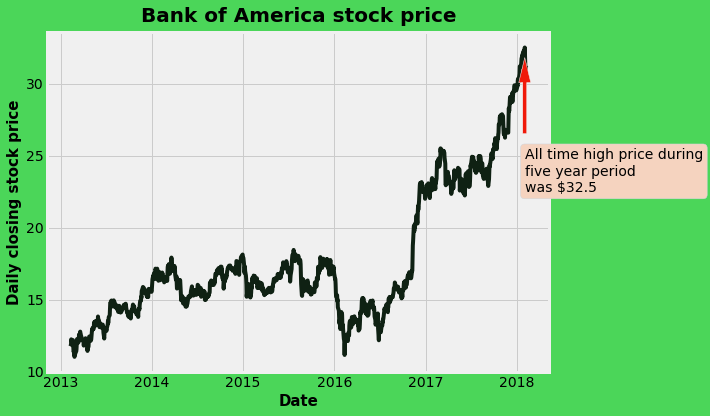

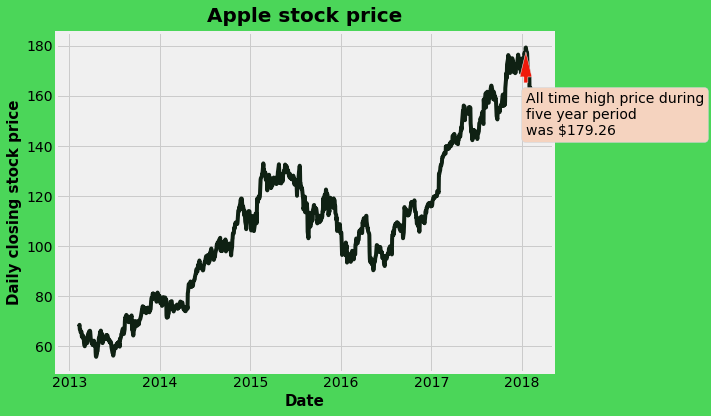

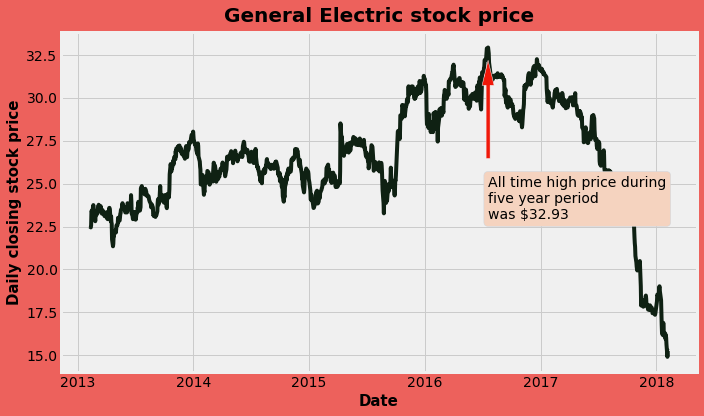

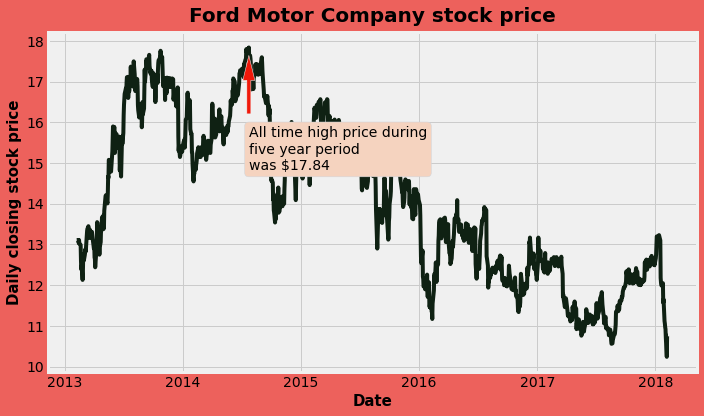

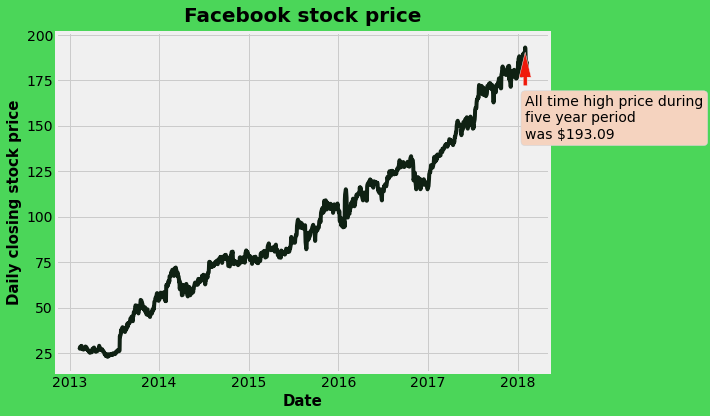

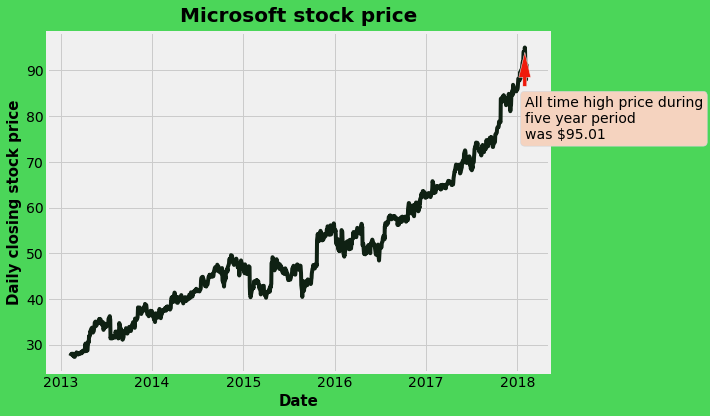

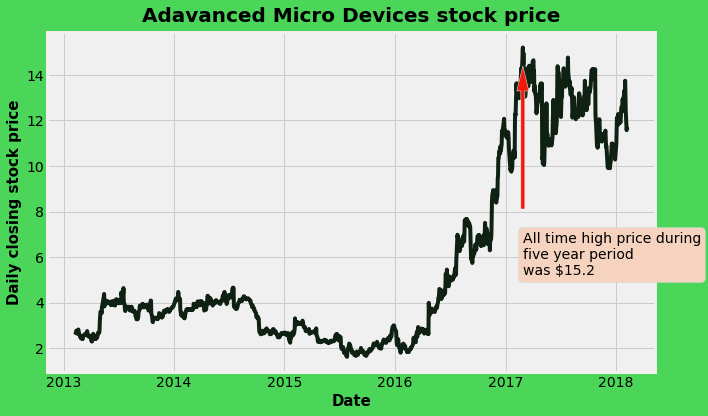

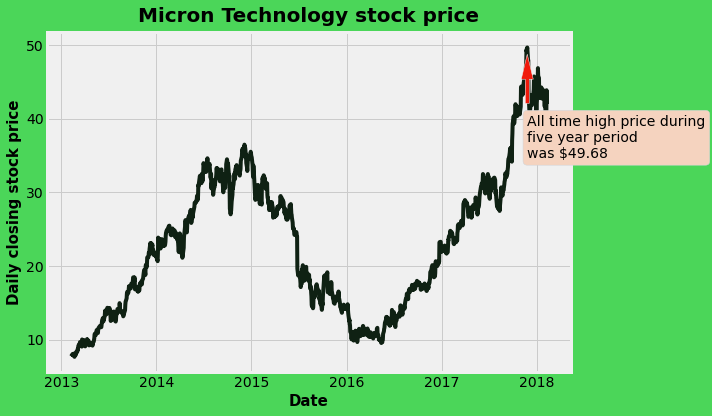

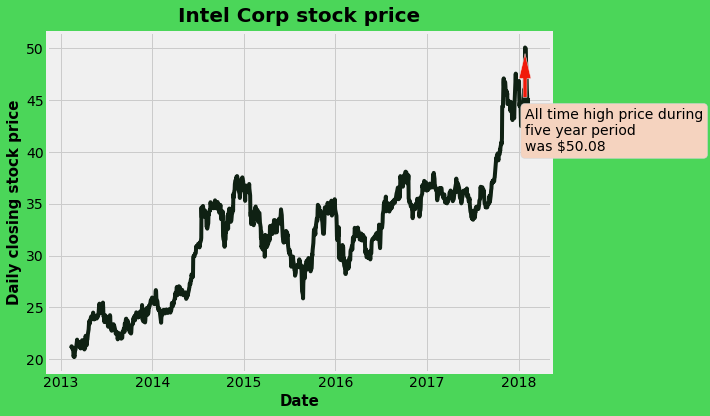

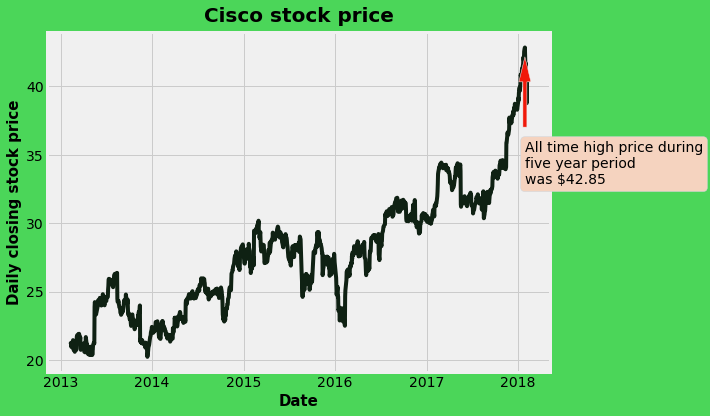

In [10]:
# function return closing stock price over a 5 years of time period
def closing_stock_price(df):
    
    # define highest stock over 5 period of time with date of the same
    high = df['close'].max()
    datetime = df[df['close'] == df['close'].max()]['date'].values
    
    if df['ticks'].unique()[0] == 'GE':
        fig, ax = plt.subplots(figsize=(10,6), facecolor='#ed615c')
    elif df['ticks'].unique()[0] == 'F':
        fig, ax = plt.subplots(figsize=(10,6), facecolor='#ed615c')
    else:
        fig, ax = plt.subplots(figsize=(10,6), facecolor='#4bd659')
    ax.plot(df['date'], df['close'], color='#0f2113')
    ax.set_title(f"{df['co_name'].unique()[0]} stock price", fontsize=20)
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Daily closing stock price", fontsize=15)
    if df['ticks'].unique()[0] == 'AAPL':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-35),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'F':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-3),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'FB':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-50),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'MSFT':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-20),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'MU':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-15),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    else:
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-10),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))

    plt.show()
    
# plot of all the closing stocks
closing_stock_price(bac_df)
closing_stock_price(aapl_df)
closing_stock_price(ge_df)
closing_stock_price(f_df)
closing_stock_price(fb_df)
closing_stock_price(msft_df)
closing_stock_price(amd_df)
closing_stock_price(mu_df)
closing_stock_price(intc_df)
closing_stock_price(csco_df)

**Key findings:**
    
- **We could find TOP 10 most traded stocks duing period of 2013-2018.**
- **Out of 10 companies one is bank, 7 of them are tech companies, another two are non-tech lagacy companies namely General electric and Ford motors.**
- **From closing stock price visualization, we can learn that stocks 'GE' and 'F' are declining and other tech stocks are rising over a five year period time.**
- **As we can see visualizations are self-explanatory and we can learn all time high stock prices of all the tickers.**

### **Lifecycle of companies and products:**

- We can observe from above plots that stock prices of companies like FORD and GE are declining while teck companies' stocks are rising rapidly. this indicates course or lifecycle of companies.
- In below image one can observe the lifecycle of any company or product from startup phase to decline stage. this is the most general theory in business that typical companies  follow such cycles.
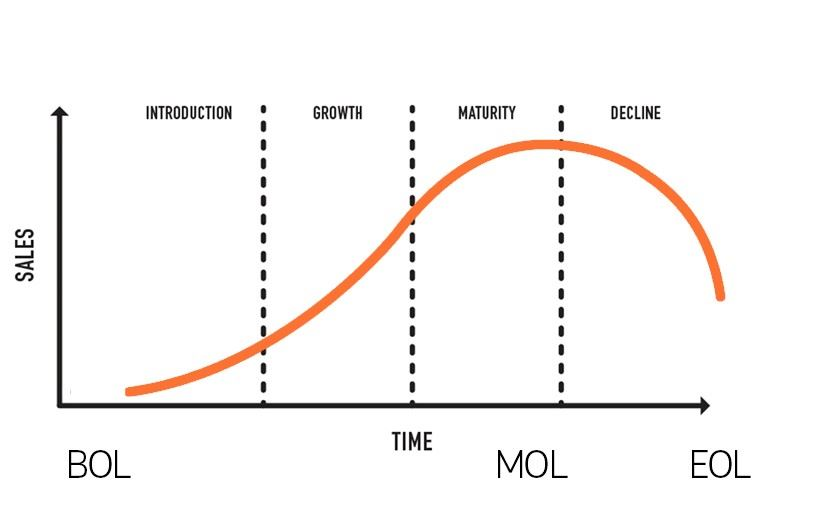

### <h1 style='background:#ed615c; border:0; border-radius: 10px; color:black'><right> Trade volume of stocks over a period of 2013-2018 </right></h1>
<a id='trade'></a>

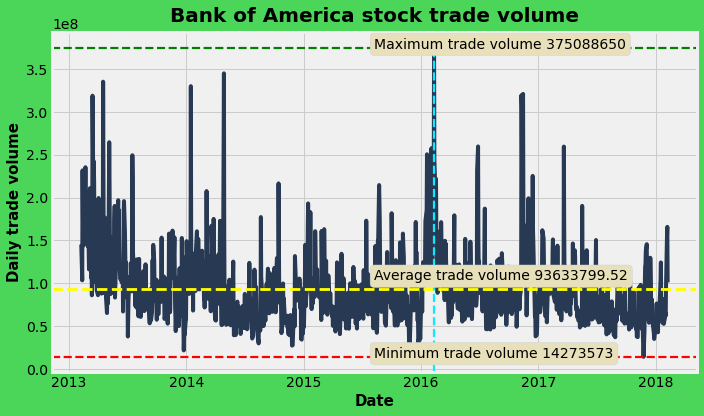

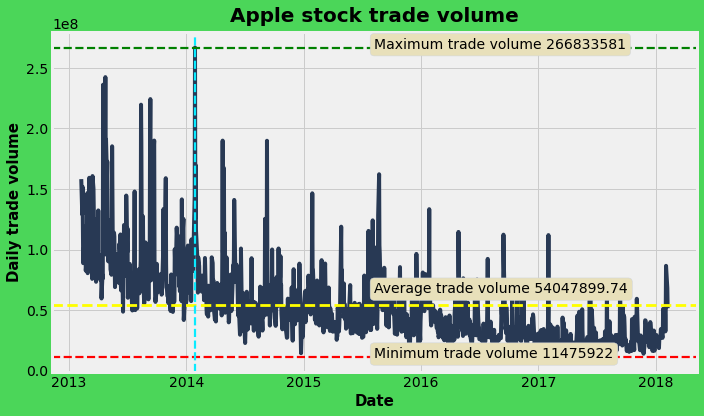

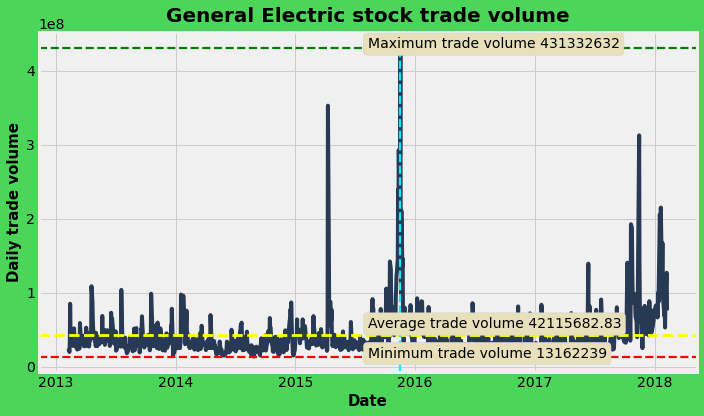

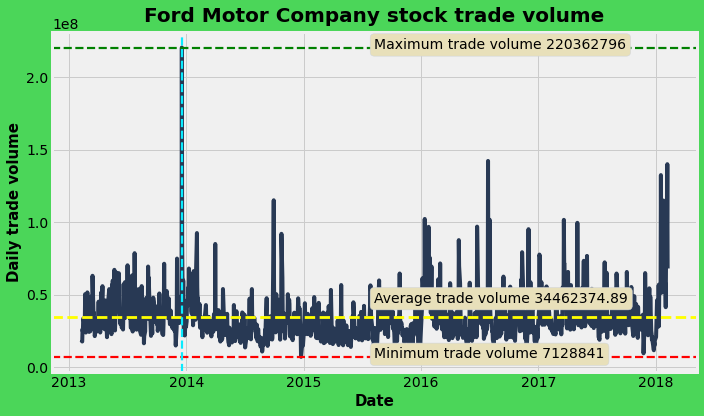

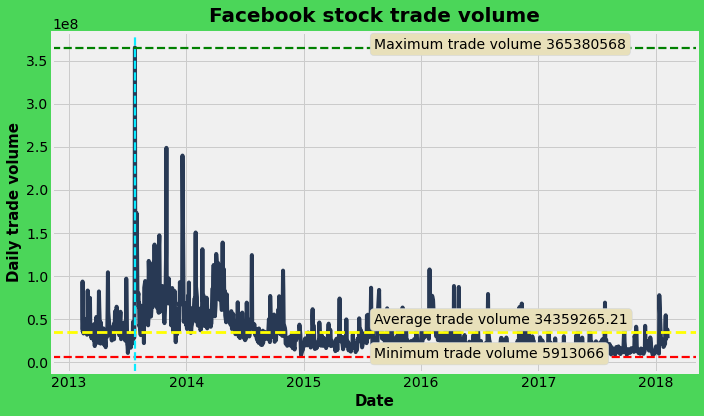

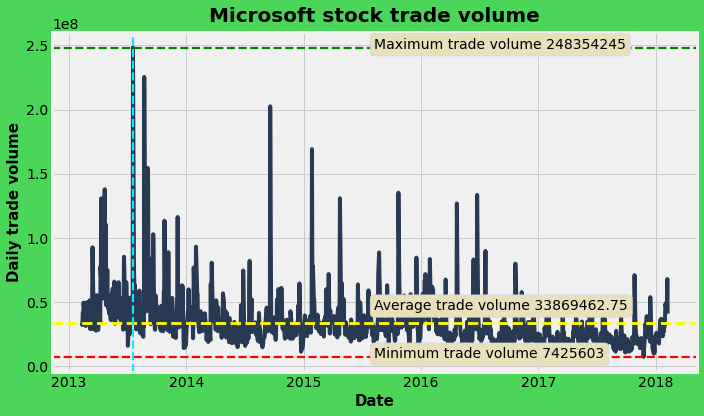

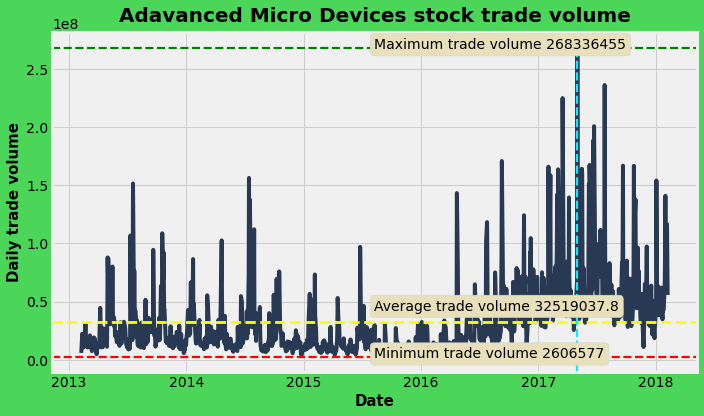

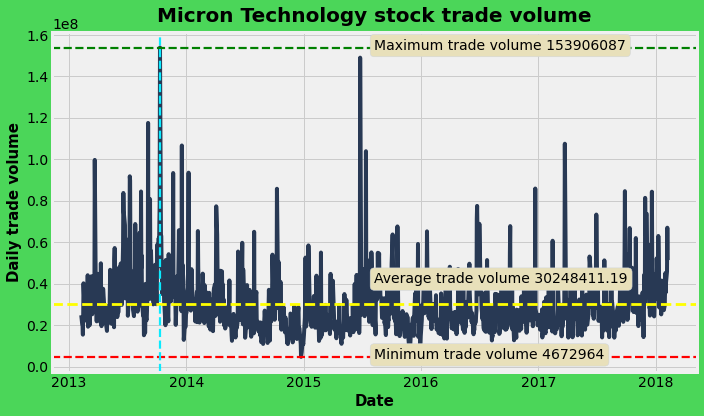

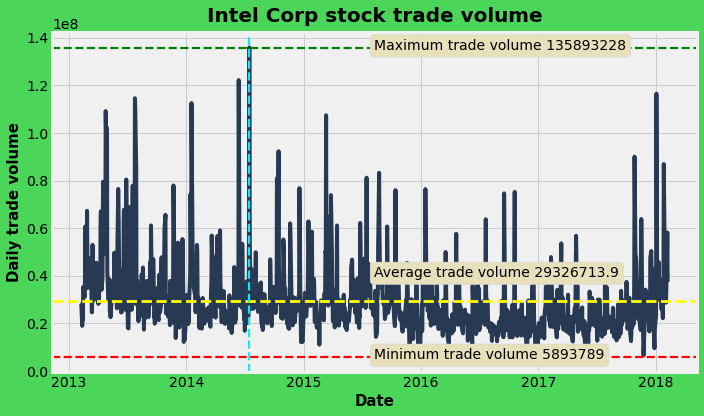

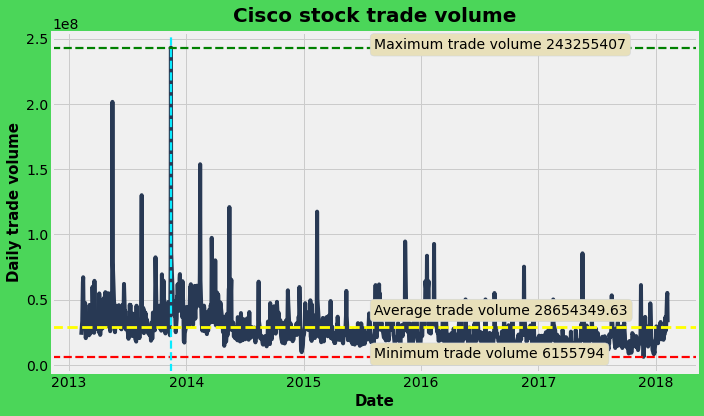

In [11]:
# function to visualize trade volume of stocks
def trade_vol(df):
    
    # x and y coords for average trade volume
    ave_x = df['date'].mean()
    ave_y = df['volume'].mean()
    # y coord for max trade vol
    max_y = df['volume'].max()
    # y coord for min trade vol
    min_y = df['volume'].min()
    
    fig, ax = plt.subplots(figsize=(10,6), facecolor='#4bd659')
    ax.plot(df['date'], df['volume'], color='#283954')
    ax.set_title(f"{df['co_name'].unique()[0]} stock trade volume", fontsize=20)
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Daily trade volume", fontsize=15)
    ax.axhline(y=df['volume'].max(), linestyle='--', lw=2.2, color='green')
    ax.axhline(y=df['volume'].min(), linestyle='--',lw=2.2, color='red')
    ax.axhline(y=df['volume'].mean(), linestyle='--',lw=2.8, color='yellow')
    ax.axvline(x=df[df['volume'] == max_y]['date'].values, ls='--', lw='2.2', color='#0aebff')
    ax.annotate(f"Average trade volume {round(df['volume'].mean(),2)}", 
                xy=(ave_x,ave_y),xytext=(ave_x,ave_y + 10000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    ax.annotate(f"Maximum trade volume {df['volume'].max()}", 
                xy=(ave_x,max_y),xytext=(ave_x,max_y - 1000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    ax.annotate(f"Minimum trade volume {df['volume'].min()}", 
                xy=(ave_x,min_y),xytext=(ave_x,min_y - 1000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    
    plt.show()
    

# plot of all stocks trade volume
trade_vol(bac_df)
trade_vol(aapl_df)
trade_vol(ge_df)
trade_vol(f_df)
trade_vol(fb_df)
trade_vol(msft_df)
trade_vol(amd_df)
trade_vol(mu_df)
trade_vol(intc_df)
trade_vol(csco_df)

**Observations:**

- **Above visualizations depicts what was the maximum, minimum and average trade volume overa period of 2013-2018.**
- **As visualizations are self-explanatory in nature we can also learn variance of trade volume for example stock ticker 'INTC' has a higest variance in trade volume compared other tickers.**

### <h1 style='background:#4bd659; border:0; border-radius: 10px; color:black'><right> Comparative analysis of 7 tech stocks </right></h1>  
<a id='tech'></a>

### What is comparative analysis of stocks in finance and investment industry?

- **An important aspect of the fundamental analysis of stocks is comparing stocks of the same sector. The most basic way to analyse and compare stocks from the same sector is to conduct an analysis of different ratios like Earnings per share (EPS), Price-to-Earnings (P/E Ratio), Return on Equity (ROE), Return on Capital Employed (ROCE), and Debt-to-Equity ratios, and stock-prices of various companies, trade volume of stocks.**
- **In this project, due to limited data of companies, we can only compare daily mean stock price of companies and can make inferences like stock price comparison and relative stock price fluctuations that I have mentioned below chart.**

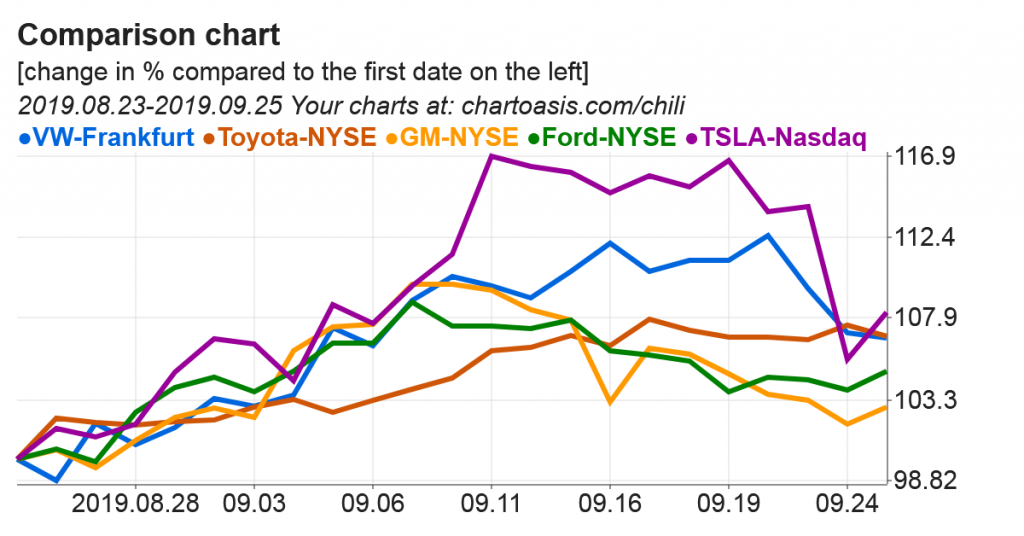

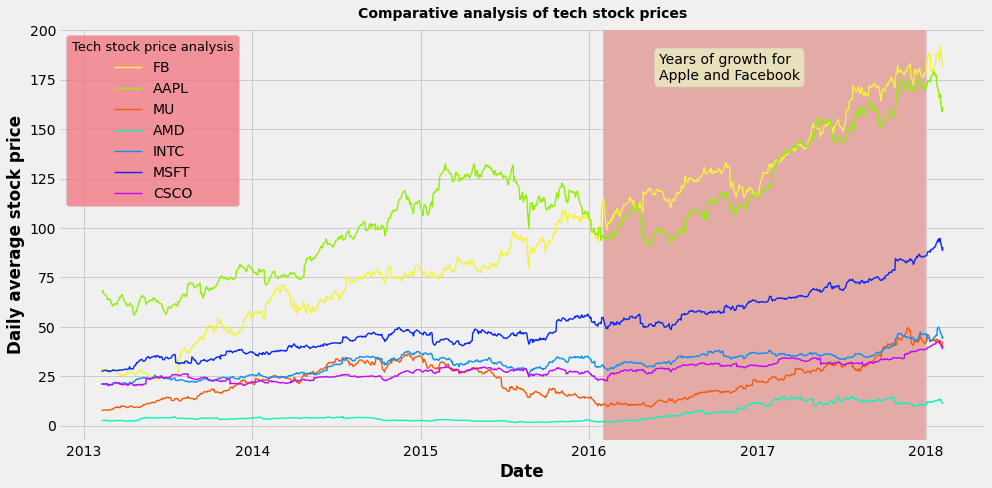

In [12]:
# tech stocks price comparison
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(fb_df['date'], fb_df['daily_mean'],label='FB', color='#f2f23f', lw=1.4)
ax.plot(aapl_df['date'], aapl_df['daily_mean'],label='AAPL', color='#92f005', lw=1.4)
ax.plot(mu_df['date'], mu_df['daily_mean'],label='MU', color='#f55c0a', lw=1.4)
ax.plot(amd_df['date'], amd_df['daily_mean'],label='AMD', color='#0af5ba', lw=1.4)
ax.plot(intc_df['date'], intc_df['daily_mean'],label='INTC', color='#0a93f5', lw=1.4)
ax.plot(msft_df['date'], msft_df['daily_mean'],label='MSFT', color='#0a29f5', lw=1.4)
ax.plot(csco_df['date'], csco_df['daily_mean'],label='CSCO', color='#c20af5', lw=1.4)
ax.axvspan(*mdates.datestr2num(['2/1/2016','12/31/2017']), color='#e3aaa6')
ax.set_title("Comparative analysis of tech stock prices")
ax.annotate("Years of growth for\nApple and Facebook", xy=(mdates.datestr2num('6/1/2016'),175),
           bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db'))
ax.set_xlabel("Date")
ax.set_ylabel("Daily average stock price")
ax.legend(facecolor='#f27985', fontsize="medium", title="Tech stock price analysis", title_fontsize=13)

plt.show()

**Observations**

- **It is very clear that 'FB' stock was one of the most expensive among all 7 tech stocks**
- **stock ticker 'AMD' was among the cheapest to buy compared to other stocks**
- **From above chart we can also conclude that stocks like 'FB' and 'AAPL' were also among the most volatile in nature than other stocks**

### What is volatility?👀📈

> **In finance, volatility (usually denoted by σ) is the degree of variation of a trading price series over time, usually measured by the standard deviation of logarithmic returns.**
> 

*source: wikipedia*

**In layman terms, volatility is nothing but the fluctuation of stock price during given period of time**

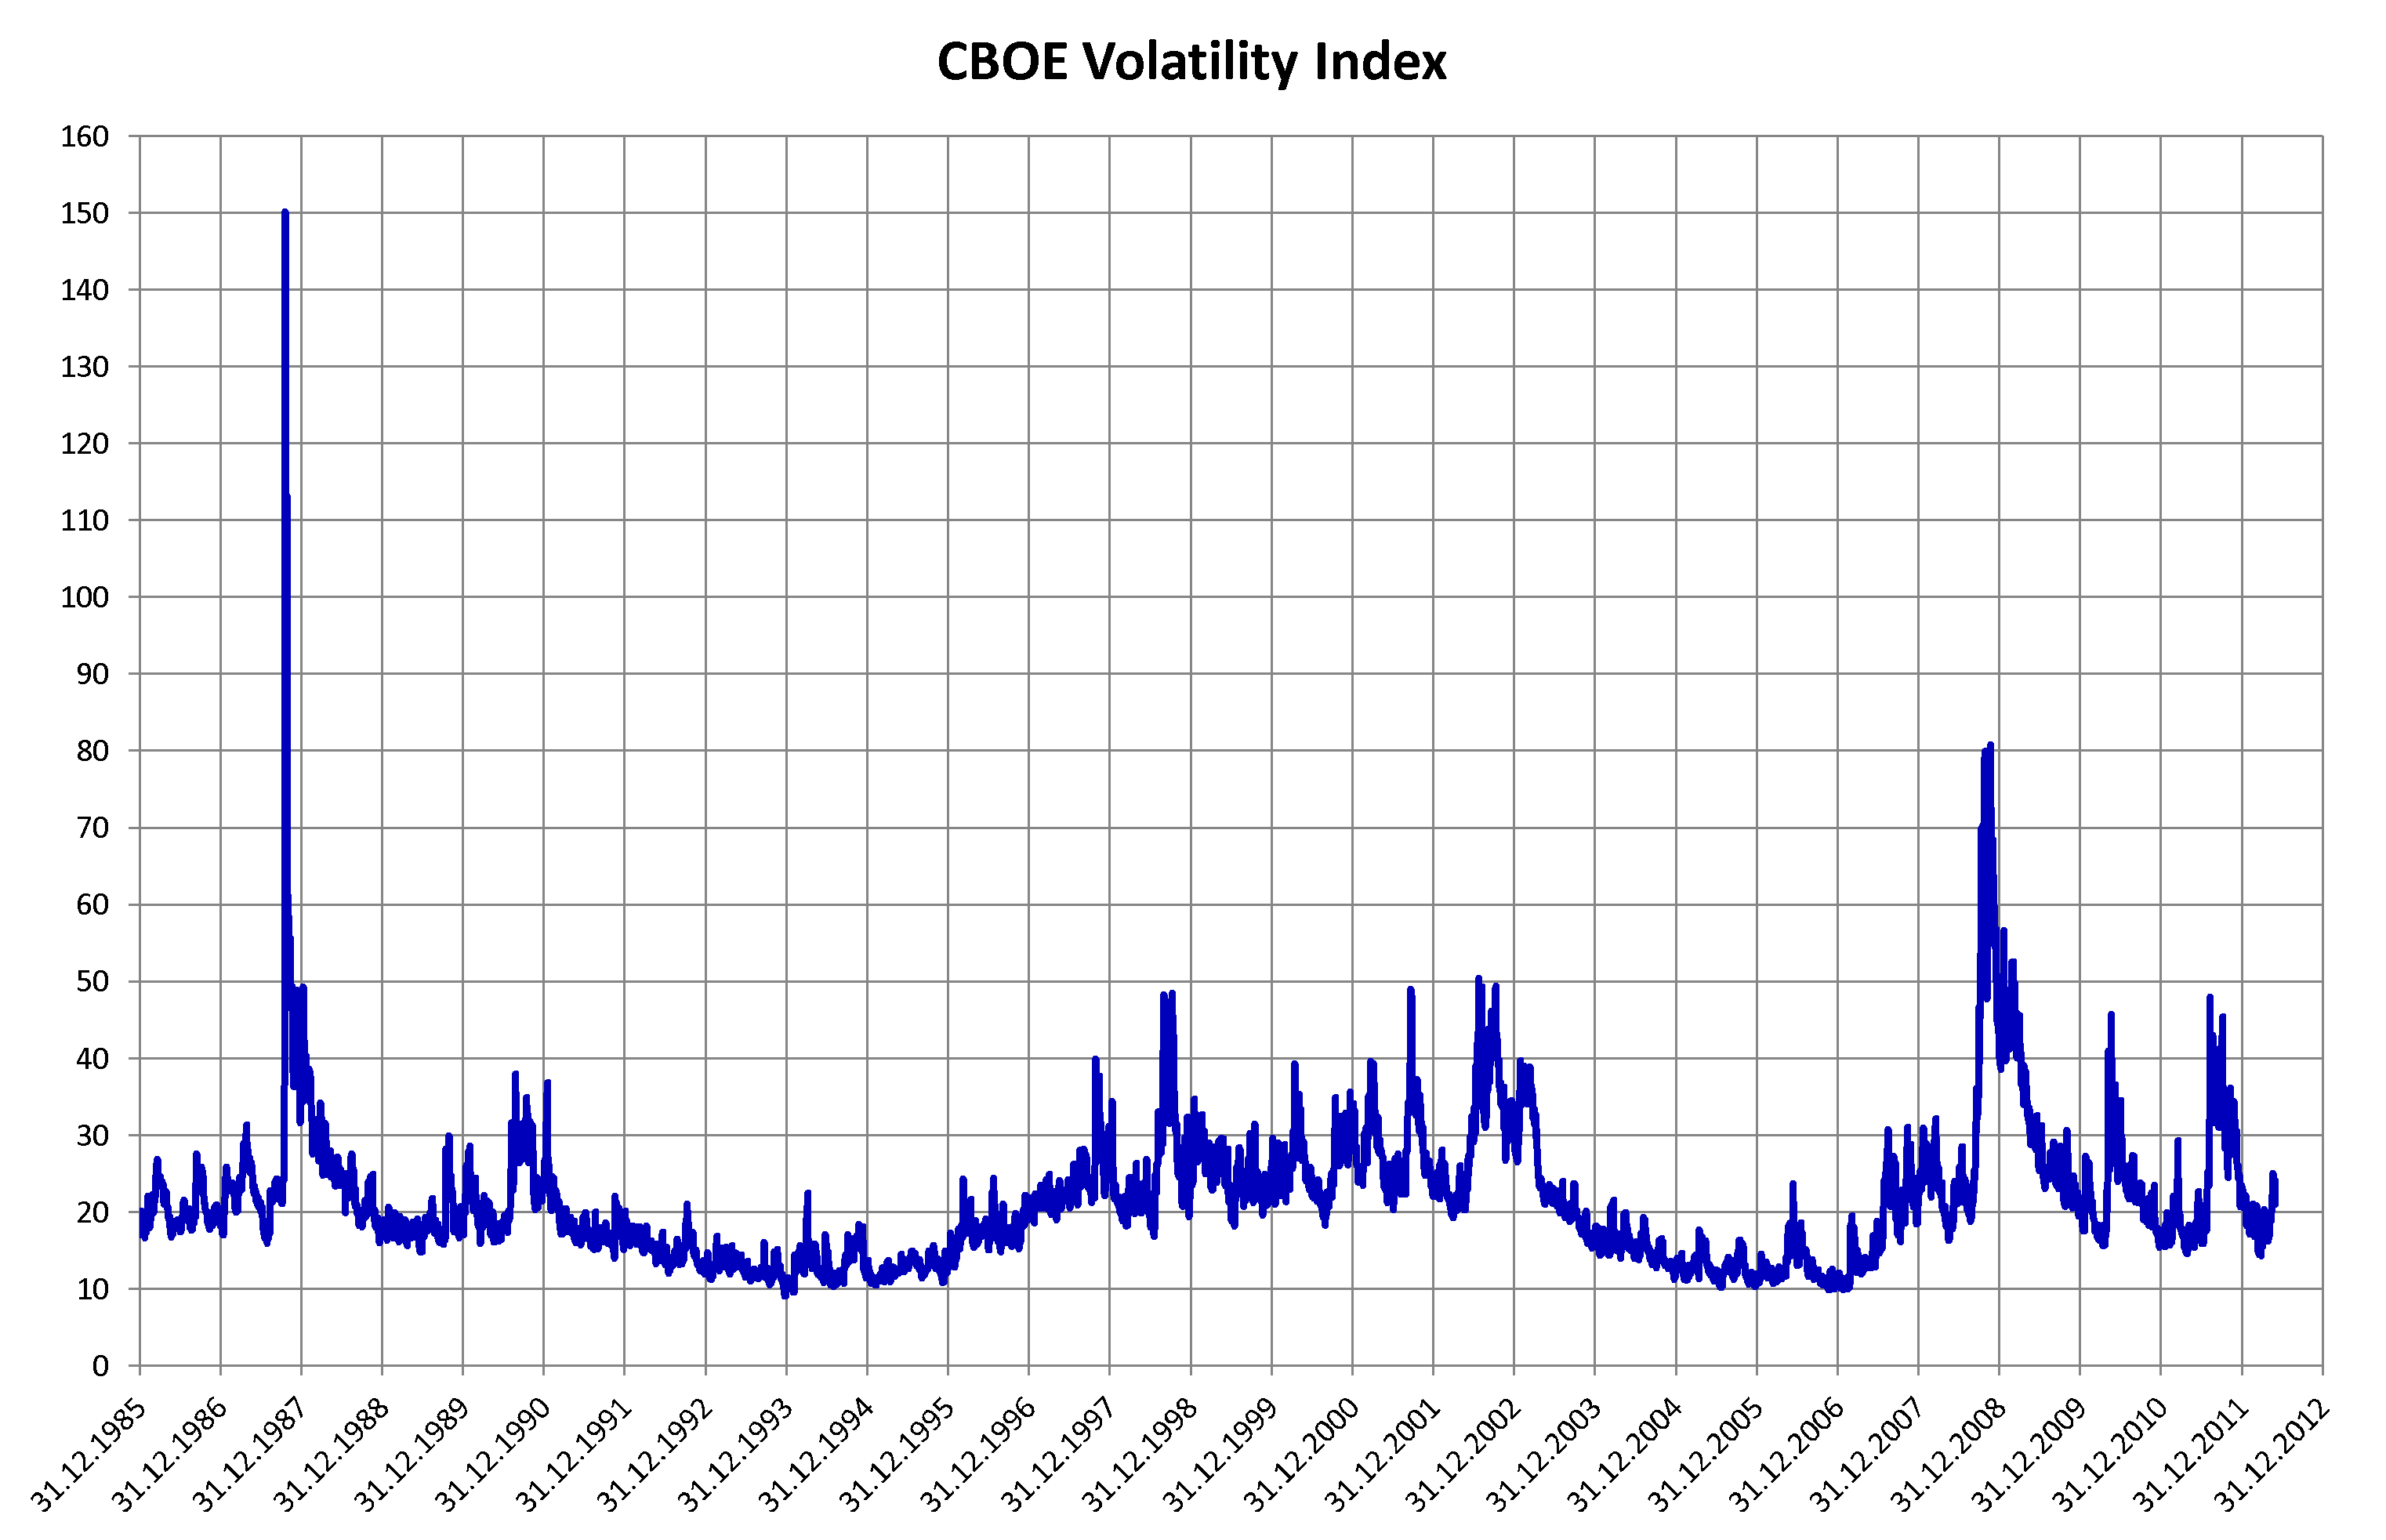

### <h1 style='background:#ed615c; border:0; border-radius: 10px; color:black'><right> Find out growth of stocks of the companies over a 5 years period </right></h1>
<a id='growth'></a>

 ### Growth of stock prices

- **In finance and investment industry, stock price growth is really important metric one needs to measure to find out the how is stock or investment of an individual is growing**
- **Below is the formula to find out growth of stock prices**

*source: educba.com*

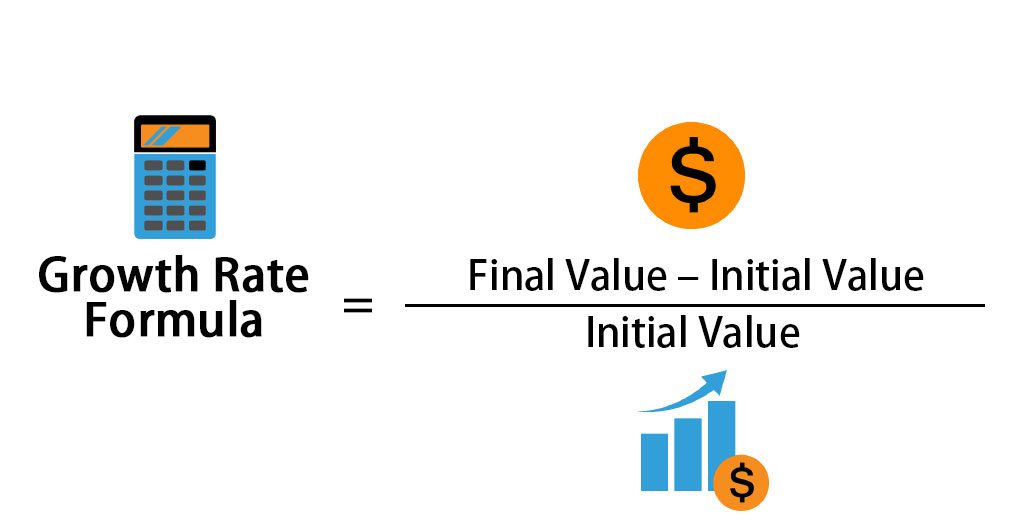

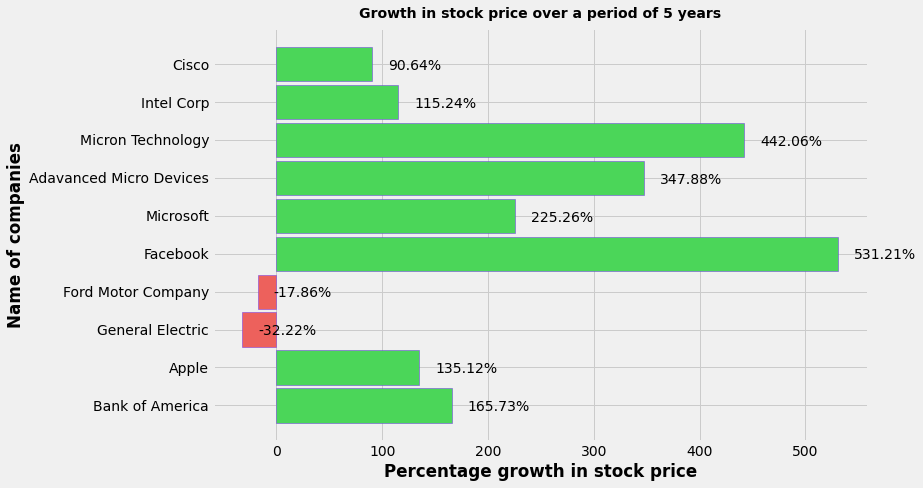

In [13]:
# list of stock dataframes
list_df = [bac_df, aapl_df, ge_df, f_df, fb_df, msft_df, amd_df, mu_df, intc_df, csco_df]

# loop through the the list_df to find mini and maxi of each stocks 
mini = [df[df['date'] == df['date'].min()]['close'].values.item() for df in list_df]
maxi = [df[df['date'] == df['date'].max()]['close'].values.item() for df in list_df]

# find list of abosolute difference between both stock price
diff = np.array(maxi) - np.array(mini)

# find the percentage growth
growth = (diff/mini)*100
growth_list = growth.tolist()
co_name_list = [df['co_name'].unique()[0] for df in list_df]

# visualize the growth of the stocks
fig, ax = plt.subplots(figsize=(13,7))
ax.barh(y=co_name_list, width=growth_list, height=0.9, color=['#4bd659','#4bd659','#ed615c','#ed615c','#4bd659',
                                                             '#4bd659','#4bd659','#4bd659','#4bd659','#4bd659'],
       edgecolor='#713ae8')
for p in ax.patches:
    ax.annotate(f'{round(p.get_width(),2)}%', (p.get_width()+15, p.get_y() +0.3))
ax.set_xlabel('Percentage growth in stock price')
ax.set_ylabel('Name of companies')
ax.set_title("Growth in stock price over a period of 5 years")
plt.show()

**Observations**

- **We can observe that growth of stock 'Facebook' is the highest among all other 10 stocks over a period of 5 years**
- **It is very much self-explanotary that stocks of 'Ford Motors' and 'General Electric' has given negative return over a years of period.**

### <h1 style='background:#4bd659; border:0; border-radius: 10px; color:black'><right> Daily return of stock prices analysis </right></h1>

<a id='dr'></a>

### Daily return hypothesis

- **In stock market, you will often hear that daily return of any stock price is 0% which means you will get zero return on your investment in one day.**
- **So let's prove the hypothesis by analysing top 10 most traded stocks and assesing their daily return distribution in this section**

- **H0: Daily return is zero**
- **Ha: Daily return is not zero**

- **We will prove this hypothesis as a one sample t-test as we know population mean but are not aware of std deviation. if p-value is greater than 0.05 than we can not reject the null hypothesis and if it is less than 0.05 than we have to reject the null hypothesis**

In [14]:
# python's scipy.stats module has ttest_1samp method we allows to prove this hypothesis
result_dict = {}
for df in list_df:
    result = stats.ttest_1samp(df['daily return'], 0)
    result_dict[df['ticks'].unique()[0]] = result   
result_dict

{'BAC': Ttest_1sampResult(statistic=-0.3532776176429947, pvalue=0.7239395130534507),
 'AAPL': Ttest_1sampResult(statistic=0.41429430560560787, pvalue=0.6787292124343913),
 'GE': Ttest_1sampResult(statistic=-0.6899014787481074, pvalue=0.4903833915917716),
 'F': Ttest_1sampResult(statistic=-1.829967497402379, pvalue=0.06749132535767648),
 'FB': Ttest_1sampResult(statistic=0.43179923117451596, pvalue=0.6659613318143065),
 'MSFT': Ttest_1sampResult(statistic=2.936864998172622, pvalue=0.00337582087561039),
 'AMD': Ttest_1sampResult(statistic=0.5320769266138294, pvalue=0.5947666691710993),
 'MU': Ttest_1sampResult(statistic=-0.3912233565721498, pvalue=0.6956983959552626),
 'INTC': Ttest_1sampResult(statistic=3.0472693720373076, pvalue=0.002357434011831407),
 'CSCO': Ttest_1sampResult(statistic=2.6892871186777536, pvalue=0.007255138945761972)}

- **From above results, we can learn that pvalues of stocks 'MSFT'.'INTC' and 'CSCO' are less than 0.05 so we can reject the null hypothesis and accept alternative hypothesis that is 'Daily return is not zero' while for other stocks we cannot reject null hypothesis.**

- **Stistically it proves that 7 out of 10 have daily return of zero percentage which is the most general case.**

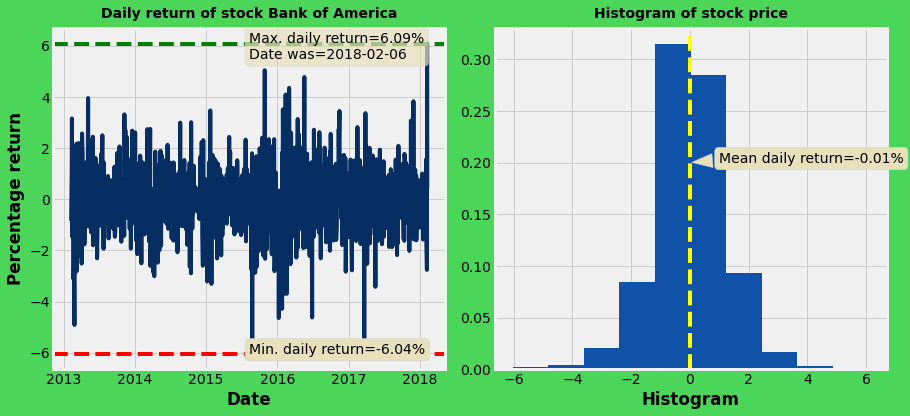

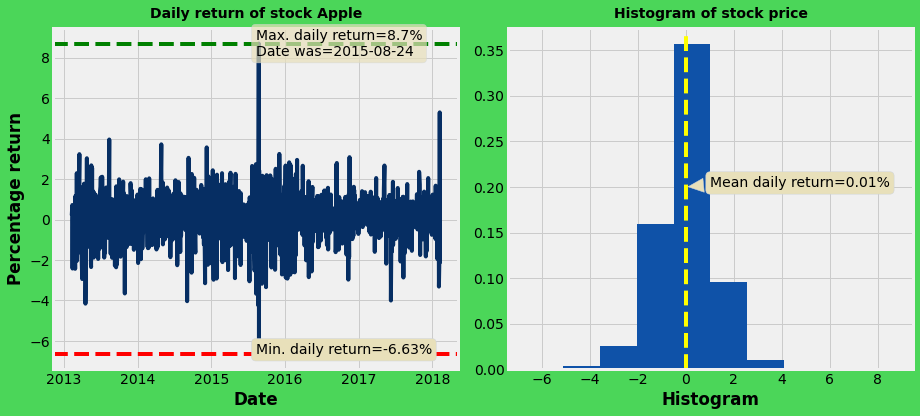

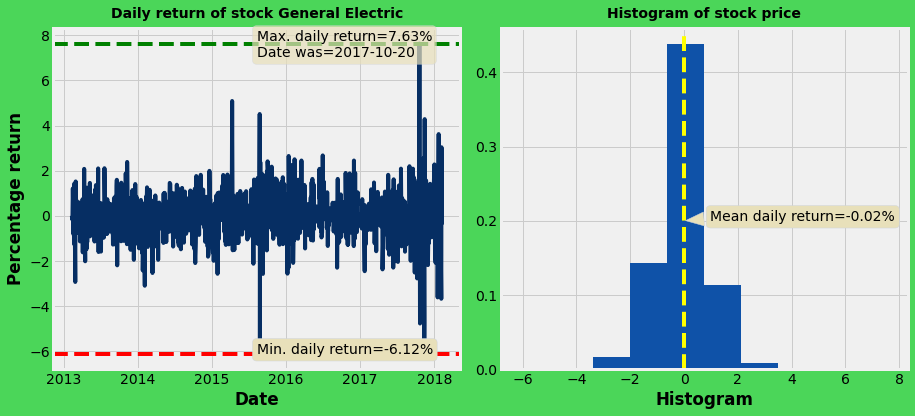

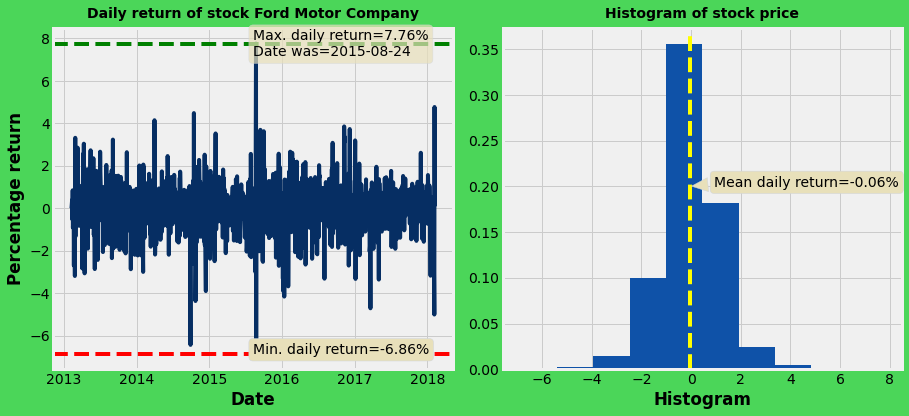

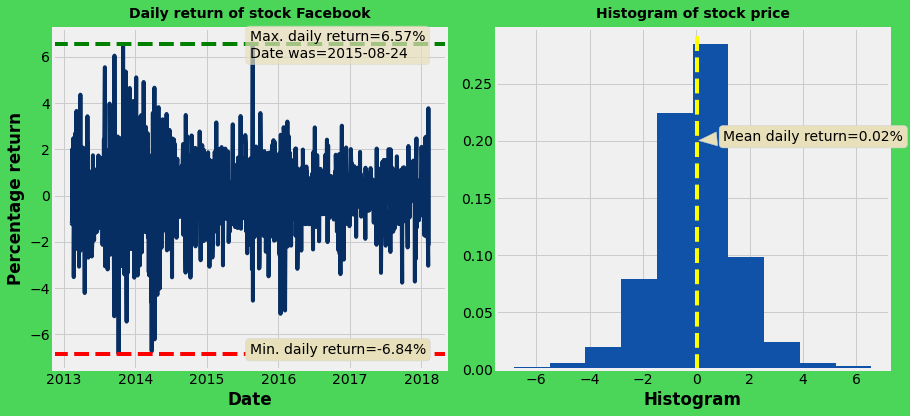

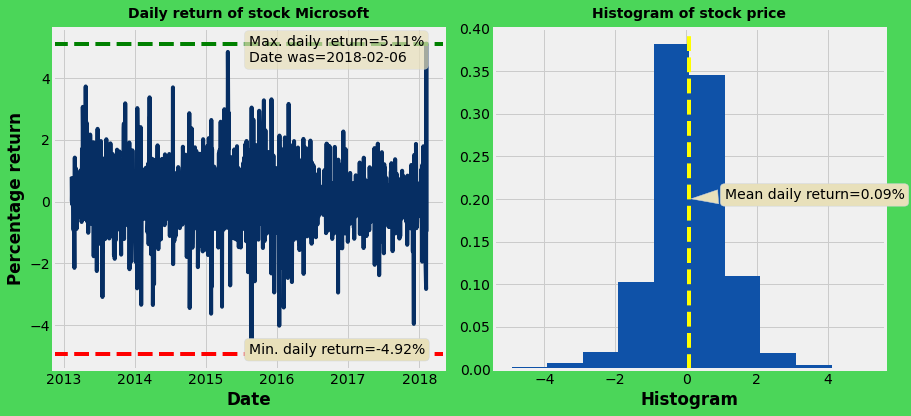

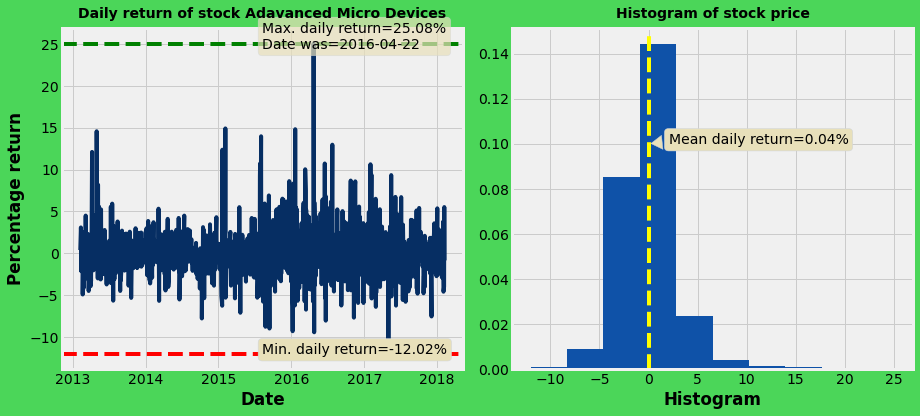

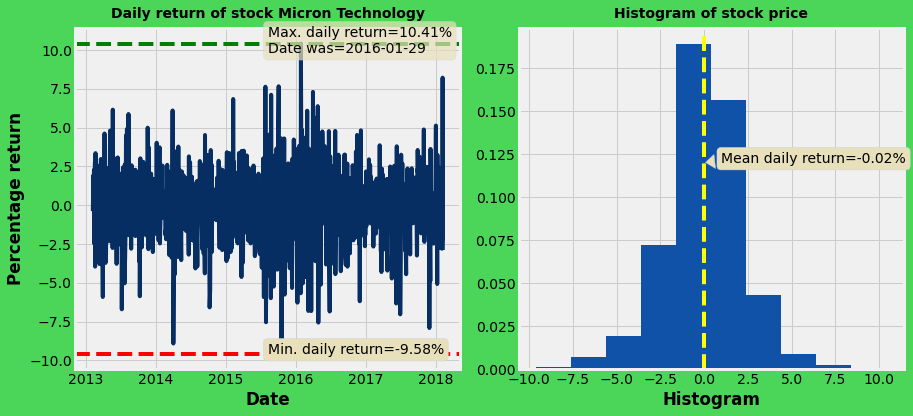

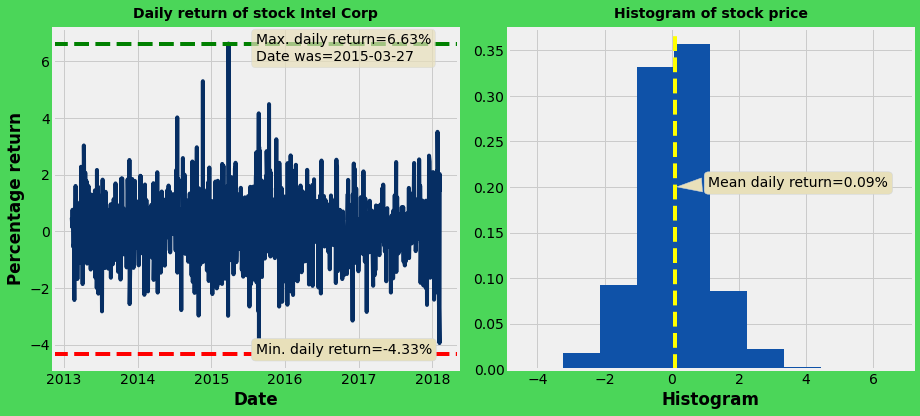

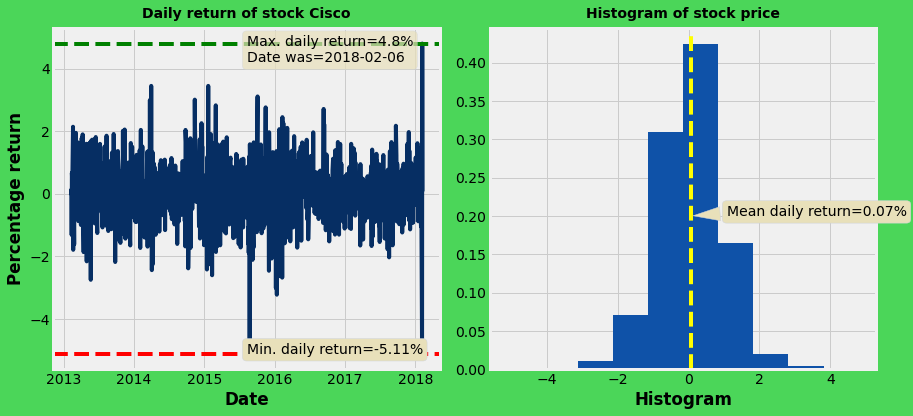

In [15]:
###### function to plot daily return and histogram of 10 stocks
def daily_return(df):
    
    # assign variables to annotation positions
    ave_x = df['date'].mean()
    y_max = df['daily return'].max()
    y_max_date = df[df['daily return'] == df['daily return'].max()]['date'].values
    dt = pd.to_datetime(y_max_date, '%Y%m%d%H%M%S')
    xb = dt.item().date()
    y_min = df['daily return'].min()
    y_mean = df['daily return'].mean()
    
    plt.figure(figsize=(13,6), facecolor='#4bd659')
    
    plt.subplot(121)
    plt.plot(df['date'], df['daily return'], color='#062e63')
    plt.axhline(y=df['daily return'].max(), color='green', ls='--')
    plt.axhline(y=df['daily return'].min(), color='red', ls='--')
    plt.xlabel('Date')
    plt.ylabel("Percentage return")
    plt.annotate(f"Min. daily return={round(df['daily return'].min(),2)}%", 
                xy=(ave_x,y_min),xytext=(ave_x,y_min),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    plt.annotate(f"Max. daily return={round(df['daily return'].max(),2)}%\nDate was={xb}", 
                xy=(ave_x,y_max),xytext=(ave_x,y_max-0.6),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db', alpha=0.7)
                 )
    plt.title(f"Daily return of stock {df['co_name'].unique()[0]}")
    
    plt.subplot(122)
    plt.hist(df['daily return'], density=True, color='#0f52a8')
    plt.xlabel('Histogram')
    plt.axvline(x=df['daily return'].mean(), color='yellow', ls='--')
    if df['ticks'].unique()[0] == 'AMD':
        plt.annotate(f"Mean daily return={round(df['daily return'].mean(),2)}%", 
                xy=(y_mean,0.10),xytext=(y_mean+2,0.10),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db'),
                arrowprops=dict(arrowstyle="wedge,tail_width=1.",facecolor='#e8e0ba', 
                            edgecolor='#d0d5db',
                            relpos=(0.1,0.5)
                            )
                 )
    elif df['ticks'].unique()[0] == 'MU':
        plt.annotate(f"Mean daily return={round(df['daily return'].mean(),2)}%", 
                xy=(y_mean,0.12),xytext=(y_mean+1,0.12),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db'),
                arrowprops=dict(arrowstyle="wedge,tail_width=1.",facecolor='#e8e0ba', 
                            edgecolor='#d0d5db',
                            relpos=(0.1,0.5)
                            )
                 )
    else:
        plt.annotate(f"Mean daily return={round(df['daily return'].mean(),2)}%", 
                xy=(y_mean,0.20),xytext=(y_mean+1,0.20),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db'),
                arrowprops=dict(arrowstyle="wedge,tail_width=1.",facecolor='#e8e0ba', 
                            edgecolor='#d0d5db',
                            relpos=(0.1,0.5)
                            )
                 )
    plt.title(f"Histogram of stock price")
    
    plt.show()
    
# call the function with dataframe
daily_return(bac_df)
daily_return(aapl_df)
daily_return(ge_df)
daily_return(f_df)
daily_return(fb_df)
daily_return(msft_df)
daily_return(amd_df)
daily_return(mu_df)
daily_return(intc_df)
daily_return(csco_df)

# <h1 style='background:red; border:0; border-radius: 10px; color:black'><right> Technical analysis of stocks using candle stick charts and moving average </right></h1>
<a id='ta'></a>


### Technical analysis of stocks

- **An open-high-low-close chart (also OHLC) is a type of chart typically used to illustrate movements in the price of a financial instrument over time. Each vertical line on the chart shows the price range (the highest and lowest prices) over one unit of time, e.g., one day or one hour. Tick marks project from each side of the line indicating the opening price (e.g., for a daily bar chart this would be the starting price for that day) on the left, and the closing price for that time period on the right. The bars may be shown in different hues depending on whether prices rose or fell in that period.**

*source: Wikipedia*

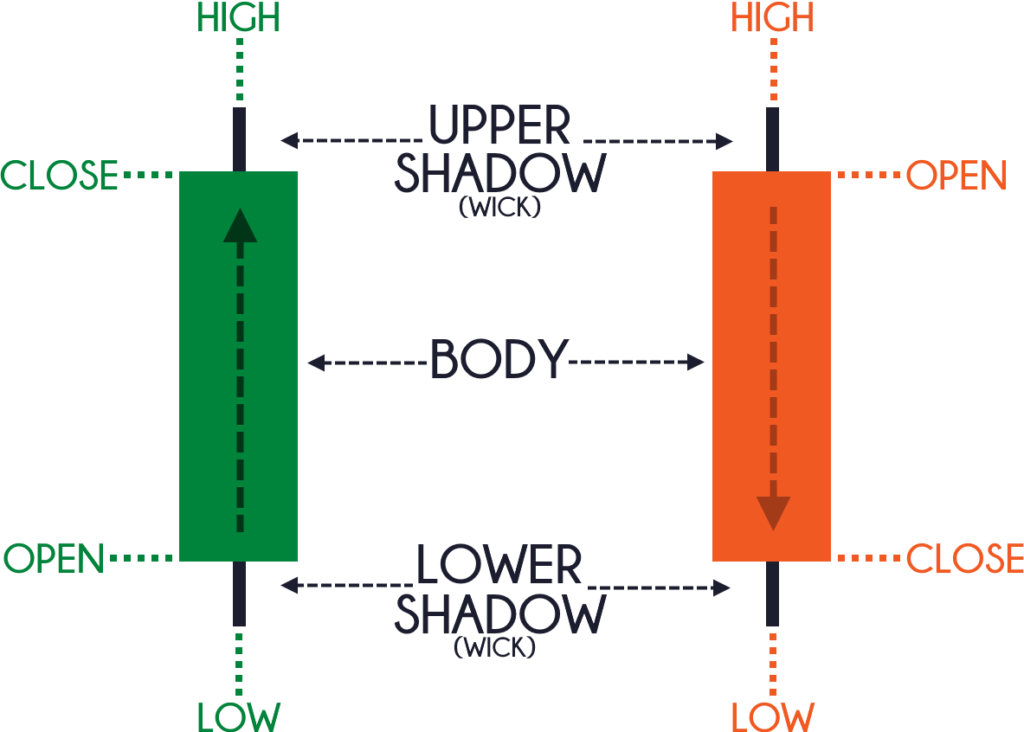

## WORK IN PROGRESS⚠

In [16]:
# ohlc and candle stick charts
# reletive performance of stocks to pick best stocks
# moving averages of stocks 
# forecasting models and insights to takeaway

# question to answer, does daily change in stock price normally distributed and mean of that
# distribution is zero??

#roadmap: 1)explore the data 2) analysis of the data 3) interpretation 4) forecasting models (why some models and 
# some don't, experiments and exaplanation with useful tips)